<a href="https://colab.research.google.com/github/AntonioNvs/projects-of-data-science/blob/main/An%C3%A1lise-de-Complexidade-de-Frases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identificação de complexidade de uma frase
##### Aplicação de revisão de inglês


O objetivo desse código é explorar, a partir da construção de uma rede neural profunda, a capacidade de análise de complexidade de uma frase em inglês em níveis, classificados como:

- 1 - Fácil entendimento
- 2 - Médio entendimento
- 3 - Difícil entendimento

De tal forma, foi utilizado como base de treino frases classificadas previamente por minha pessoa, logo, a complexidade está intrinsicamente ligada ao meu conhecimento próprio atual, posto que algo ser complexo é relativo e depende do indivíduo no momento medido.

Assim, o processo será dividido em N etapas:

- **Importação dos dados e das bibliotecas**
- **Manipulação dos dados**
- **Análise exploratória**
- **Construção do modelo**
- **Treinamento da rede neural**

Ademais, ao final, foi feito um segundo modelo, a partir da média de frequência das palavras na frase, segundo um banco de dados pré-definido.


## Importação dos dados e das bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import chardet

In [ ]:
# Operação para identificar qual o tipo de encodificação do arquivo
with open('drive/MyDrive/Projetos/English/phrases.csv', 'rb') as f:
    result = chardet.detect(f.read())

# Lendo os dados e verificando as colunas visualmente
data = pd.read_csv('drive/MyDrive/Projetos/English/phrases.csv', encoding=result['encoding'],quotechar='"')
data.head()

,id,phrase,document_id,level
0,3157,to the environment and climate,10,1.0
1,115,This is not a pipe dream,1,2.0
2,98,decades before a large Tesla semitruck.,1,1.0
3,3833,and understand exactly what motivates them,11,1.0
4,2220,it sounds really epic.,8,1.0


# Manipulação dos dados

In [ ]:
# Eliminando linhas vazias
data = data.dropna()

In [ ]:
# Separando as colunas de entrada e saída

sentences = data['phrase']
labels = data['level']

In [ ]:
# Transformando cada nível em uma coluna de classificação
labels = pd.get_dummies(labels)

In [ ]:
# Renomeando as colunas de níveis
labels = labels.rename(columns= lambda name: str(int(name)))

In [ ]:
def processing_text(sen):
    # Removendo pontuação
    sentence = re.sub(r'[^\w\s]', '', sen)

    # Removendo caracteres únicos
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removendo múltiplos espaços
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence.lower()

In [ ]:
x = []

# Adequando as frases a um padrão
for sentence in sentences:
  x.append(processing_text(sentence))

# Separando os valores do label
y = labels.values

# Análise exploratória

### Quantidade de frases de cada nível

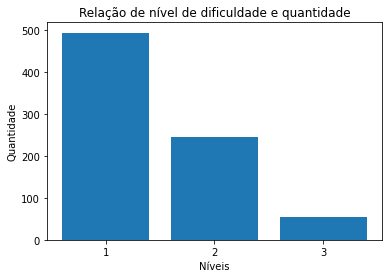

In [ ]:
# Soma de cada classificação
list_sum_values_levels = labels.value_counts()

plt.bar(labels.columns, list_sum_values_levels.values)
plt.title('Relação de nível de dificuldade e quantidade')
plt.xlabel('Níveis')
plt.ylabel('Quantidade')

plt.show()

Um dos tópicos principais dessa análise é ver o nível de dificuldade que a pessoa enfrenta.

Percebe-se então a maior quantidade de classificações 'fácil' e 'média', demonstra um inglês intermediário.

### Dificuldade de cada palavra

In [ ]:
# Dicionário de palavras
words = {}

# Iteração por cada linha
for row in data.values:
  phrase = row[1]
  level = row[3]

  # Realizando a média de nível de cada palavra
  for word in phrase.split(' '):
    try:
      words[word] = (words[word] + level) / 2
    except KeyError:
      words[word] = level

# Ordenação decrescente de nível de cada palavra
print(sorted(words.items(), reverse=True, key= lambda a: a[1]))

[('perhaps', 3.0), ('congestion', 3.0), ('offshore', 3.0), ('wind.', 3.0), ('athletic', 3.0), ('prowess,', 3.0), ('intervene', 3.0), ('statutory', 3.0), ('framework.', 3.0), ('blurry', 3.0), ('image', 3.0), ('determine', 3.0), ('self-taught', 3.0), ('youth', 3.0), ('group', 3.0), ('told', 3.0), ('plans,', 3.0), ('entirely', 3.0), ('mental.', 3.0), ('concern', 3.0), ('razor-sharp', 3.0), ('cutting', 3.0), ('secret', 3.0), ('knobs', 3.0), ('across', 3.0), ('acres', 3.0), ('land', 3.0), ('lifts,', 3.0), ('flooding', 3.0), ('laid', 3.0), ('principles.', 3.0), ('ecological', 3.0), ('retail', 3.0), ('sales', 3.0), ('stores.', 3.0), ('biased', 3.0), ('have,', 3.0), ('acknowledge', 3.0), ('destroyed', 3.0), ('hard', 3.0), ('halfway', 3.0), ('Cybernetics', 3.0), ('argued', 3.0), ('persuasively', 3.0), ('meanwhile', 3.0), ('keep', 3.0), ('cramming', 3.0), ('While', 3.0), ('sudden', 3.0), ('disappearance', 3.0), ('brought', 3.0), ('foisted', 3.0), ('permaculture', 3.0), ('ancient', 3.0), ('plants

A hipótese inicial, na qual era de que as palavras desconhecidas teriam maior nível, não é confirmada pela análise.

Nota-se palavras como 'way', 'millions' e 'age', onde possuo conhecimento da semântica, mas a média está em 3.

Portanto, verifica-se que somente com uma quantidade X de dados, muito maior que a quantidade atual, tal hipótese pode ser confirmada.

# Construção do modelo

In [ ]:
# Definição de variáveis

vocab_size = 10000 # Tamanho do vocabulário
embedding_dim = 16 # Número de dimensões da camada de embedding
max_length = 100 # Maior tamanho das frases
trunc_type = 'post' # Cortar ao final, caso a frase passa do tamanho estabelecido
padding_type = 'post' # Cortar ao final, caso a frase não alcance o maior tamanho
oov_tok = "<OOV>" # Adicionado em palavras fora do vocabulário

### Tokenizer

In [ ]:
# Importação

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
# Dividindo os dados em treino e testes
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [ ]:
tokenizer = Tokenizer(num_words=6000, oov_token=oov_tok)

# Indexização das palavras
tokenizer.fit_on_texts(x_train)

# Transformando a frase em uma lista de índices
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

word_index = tokenizer.word_index

total_words = len(tokenizer.word_index) + 1

# Transformando a lista de índices com todas do mesmo tamanho
x_train = pad_sequences(x_train, padding=padding_type, maxlen=max_length, truncating=trunc_type)
x_test = pad_sequences(x_test, padding=padding_type, maxlen=max_length, truncating=trunc_type)

### Modelo

O modelo construído possui como entrada a camada de Embedding, uma camada de ajustamento de tamanho da entrada, e duas camadas escondidas de 24 e 32 neurônios respectivamente, e 3 saídas, cada uma representando um tipo de dificuldade.

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
first_model = Sequential([
  Embedding(vocab_size, embedding_dim,input_length=max_length),
  GlobalAveragePooling1D(),
  Dense(64, activation='relu'),
  Dense(40, activation='relu'),
  Dense(len(labels.columns), activation='softmax')
])

adam = Adam(learning_rate=0.05) # Otimizador que implementa o algoritmo de Adam

first_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# Observando o modelo construído
first_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_14 (Dense)             (None, 40)                2600      
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 123       
Total params: 163,811
Trainable params: 163,811
Non-trainable params: 0
_________________________________________________________________


# Treinamento da rede neural

### Treinamento

In [ ]:
# Treinamento do modelo
history = first_model.fit(x_train, y_train, batch_size=108,epochs=15, validation_split=0.25, verbose=1)

Epoch 1/15
5/5 [==============================] - 10s 2s/step - loss: 0.5783 - accuracy: 0.6336 - val_loss: 0.5214 - val_accuracy: 0.5754
Epoch 2/15
5/5 [==============================] - 0s 12ms/step - loss: 0.5055 - accuracy: 0.6336 - val_loss: 0.5348 - val_accuracy: 0.5754
Epoch 3/15
5/5 [==============================] - 0s 10ms/step - loss: 0.5033 - accuracy: 0.6336 - val_loss: 0.5183 - val_accuracy: 0.5754
Epoch 4/15
5/5 [==============================] - 0s 12ms/step - loss: 0.4983 - accuracy: 0.6336 - val_loss: 0.5229 - val_accuracy: 0.5754
Epoch 5/15
5/5 [==============================] - 0s 11ms/step - loss: 0.4778 - accuracy: 0.6336 - val_loss: 0.5232 - val_accuracy: 0.5754
Epoch 6/15
5/5 [==============================] - 0s 14ms/step - loss: 0.3935 - accuracy: 0.6972 - val_loss: 0.7296 - val_accuracy: 0.5754
Epoch 7/15
5/5 [==============================] - 0s 12ms/step - loss: 0.3176 - accuracy: 0.7981 - val_loss: 0.7609 - val_accuracy: 0.4302
Epoch 8/15
5/5 [============

### Verificação

In [ ]:
# Resultado dos parâmetros de acurácia e perda do modelo

score = first_model.evaluate(x_test, y_test, verbose=1)

3/3 [==============================] - 0s 4ms/step - loss: 1.7759 - accuracy: 0.5500


### Conclusão

A lógica da rede neural é coerente, entretanto, foi visto a falta de dados existente para a obtenção de uma classificação adequada. Com uma taxa de acurácia aproximada de 62% nos dados de treino, classifica-se o modelo como bom, mas não o ideal a ser aplicado, principalmente pela alta taxa de classificação como 'fácil'.

# Classificando o resto das frases

In [ ]:
# Operação para identificar qual o tipo de encodificação do arquivo
with open('drive/MyDrive/Projetos/English/all_phrases.csv', 'rb') as f:
    result = chardet.detect(f.read())

# Lendo os dados e verificando as colunas visualmente
all_data = pd.read_csv('drive/MyDrive/Projetos/English/all_phrases.csv', encoding=result['encoding'],quotechar='"')
all_data.head()

,id,phrase,document_id
0,1,"I work in aviation, but the truth is",1
1,2,I don't much like flying.,1
2,3,Current commercial flights,1
3,6,and use ancient plane designs,1
4,7,that have hardly changed from the 1950s.,1


In [ ]:
# Eliminando as linhas vazias
all_data = all_data.dropna()

In [ ]:
x = []

# Adequando as frases a um padrão
for sentence in all_data['phrase'].values:
  x.append(processing_text(sentence))

In [ ]:
x = tokenizer.texts_to_sequences(x)

x = pad_sequences(x, padding=padding_type, maxlen=max_length, truncating=trunc_type)

In [ ]:
all_predicteds = list()

def index_of_max_value(array):
  max_value = -1
  ind = 0

  for i, prob in enumerate(array):
    if prob > max_value:
      ind = i
      max_value = prob

  return ind

for i, value in enumerate(x):
  predicted = first_model.predict([value])[0]

  level = index_of_max_value(predicted) + 1

  print(f'Predição {i}: {level}')

  all_predicteds.append(level)

all_data['complexity'] = all_predicteds

Streaming output truncated to the last 5000 lines.
Predição 135: 1
Predição 136: 1
Predição 137: 2
Predição 138: 1
Predição 139: 1
Predição 140: 1
Predição 141: 1
Predição 142: 2
Predição 143: 1
Predição 144: 1
Predição 145: 1
Predição 146: 1
Predição 147: 2
Predição 148: 2
Predição 149: 2
Predição 150: 1
Predição 151: 2
Predição 152: 1
Predição 153: 1
Predição 154: 2
Predição 155: 2
Predição 156: 2
Predição 157: 1
Predição 158: 1
Predição 159: 2
Predição 160: 2
Predição 161: 1
Predição 162: 1
Predição 163: 1
Predição 164: 2
Predição 165: 2
Predição 166: 1
Predição 167: 2
Predição 168: 1
Predição 169: 2
Predição 170: 1
Predição 171: 2
Predição 172: 2
Predição 173: 1
Predição 174: 1
Predição 175: 2
Predição 176: 1
Predição 177: 2
Predição 178: 1
Predição 179: 2
Predição 180: 1
Predição 181: 2
Predição 182: 1
Predição 183: 1
Predição 184: 1
Predição 185: 1
Predição 186: 2
Predição 187: 2
Predição 188: 1
Predição 189: 2
Predição 190: 2
Predição 191: 2
Predição 192: 2
Predição 193: 1
Predi

In [ ]:
import numpy as np
# Normalizando o resultado

comp_arr = np.array(all_data['complexity'].values)

e = (comp_arr - comp_arr.min()) / (comp_arr.max() - comp_arr.min()) * 10

all_data['normalize_complexity'] = e


In [ ]:
json_file = all_data.to_json('phrases_with_complexity.json', orient='records')

### Conclusão

O modelo condiz com a hipótese inicial: só funcionará em certos casos. A partir do treinamento, indaga-se que o modelo tende a classificar perto da média de dificuldade (0.5) nas predições, o que é ruim.

# Tentativa de outro modelo

Pela primeira tentativa, com um modelo a partir da classificação das frases e suas dificuldades, a taxa de acerto foi bem baixa quando levada para os casos de teste. Portanto, agora o modelo será outro.

A partir de uma base de dados de frequência de palavras, a rede neural irá receber como input a média da frequência das palavras da frase, e o output será o nível de dificuldade.

Por hipótese inicial, a classificação será coerente somente em alguns casos, devido ao único valor de entrada ser a frequência.

### Importação dos dados

In [ ]:
import urllib

# Requisição do arquivo a partir da url
url = 'https://raw.githubusercontent.com/hermitdave/FrequencyWords/master/content/2016/en/en_full.txt'
file = urllib.request.urlopen(url)

frequency_words = {}

# Preenchendo o dicionário de frequência de palavras
for line in file:
  decoded_line = line.decode("utf-8")
  
  word, frequency = decoded_line.split(' ')

  frequency_words[word] = int(frequency.strip())

In [ ]:
# Teste
frequency_words['hi']

250541

### Média das frequências nas frases

In [ ]:
# Separando os dados de entrada e saída

resources = data['phrase']
labels = data['level']

In [ ]:
# Calculando a média de frequência de cada frase
x = []

for sentence in resources:
  sentence = processing_text(sentence)

  mean = 0

  split_sentence = sentence.split(' ')
  size = len(split_sentence)

  for word in split_sentence:
    try:
      # Realizando a raiz da frequência, para evitar grandes valores
      mean += frequency_words[word]**0.5
    except KeyError:
      size -= 1

  # Caso não tenha nenhuma palavra na sentença, a divisão será igual a 0.
  # Portanto, a palavra é um número, cujo classificação é 'fácil'.
  try:    
    mean /= size
  except ZeroDivisionError:
    mean = max(x) 

  x.append(mean)

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Dimensionando os dados os dados
x = np.array(x).reshape(-1, 1)
sc = StandardScaler()
x = sc.fit_transform(x)

In [ ]:
# Redimensionando os valores de dificuldade
y = labels.values / 3

### Modelo

Criando o modelo com uma camada de 8 neurônios e uma camada de saída com 1.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop

model = Sequential([
    Dense(8, activation='relu', input_shape=[1]),
    Dense(1, activation='sigmoid')
  ])

optimizer = RMSprop(0.001) # Otimizador que implementa o algoritmo RMSprop

model.compile(loss="mse", optimizer=optimizer, metrics=['mse'])

In [ ]:
model.fit(x=x_train, y=y_train, epochs=15, batch_size=32)

Epoch 1/15
20/20 [==============================] - 0s 1ms/step - loss: 0.0434 - mse: 0.0434
Epoch 2/15
20/20 [==============================] - 0s 2ms/step - loss: 0.0421 - mse: 0.0421
Epoch 3/15
20/20 [==============================] - 0s 2ms/step - loss: 0.0414 - mse: 0.0414
Epoch 4/15
20/20 [==============================] - 0s 2ms/step - loss: 0.0409 - mse: 0.0409
Epoch 5/15
20/20 [==============================] - 0s 2ms/step - loss: 0.0407 - mse: 0.0407
Epoch 6/15
20/20 [==============================] - 0s 2ms/step - loss: 0.0405 - mse: 0.0405
Epoch 7/15
20/20 [==============================] - 0s 2ms/step - loss: 0.0404 - mse: 0.0404
Epoch 8/15
20/20 [==============================] - 0s 2ms/step - loss: 0.0403 - mse: 0.0403
Epoch 9/15
20/20 [==============================] - 0s 2ms/step - loss: 0.0403 - mse: 0.0403
Epoch 10/15
20/20 [==============================] - 0s 2ms/step - loss: 0.0403 - mse: 0.0403
Epoch 11/15
20/20 [==============================] - 0s 2ms/step - lo

### Verificação do modelo

In [ ]:
model.evaluate(x=x_test, y=y_test)

5/5 [==============================] - 0s 2ms/step - loss: 0.0495 - mse: 0.0495


[0.04947063699364662, 0.04947063699364662]

In [ ]:
for i in range(3):
  print(f'Predicted: {model.predict([x_test[i]])[0][0]}')
  print(f'Real value: {y_test[i]}')
  print()

Predicted: 0.474653422832489
Real value: 0.6666666666666666

Predicted: 0.4566150903701782
Real value: 1.0

Predicted: 0.48776134848594666
Real value: 0.6666666666666666



# Conclusão Geral

A lógica dos dois modelos são coerentes, entretanto, devido a baixa quantidade de dados, não foi possível comprovar a viabilidade total do primeiro modelo, tendo em vista a taxa de acurácia ligada a grande classificação das frases como fáceis. Além disso, o segundo modelo pode ser utilizado, mas o resultado final deve ser remodelado para adequar aos reais níveis de complexidade.


De tal forma, será utilizado o primeiro modelo, após uma maior classificação dos dados e assim a comprovação da hipótese de viabilidade.